In [ ]:
!pip install torch
!pip install torch_geometric
!pip install torch_scatter
!pip install torch_cluster
!pip install uproot
!pip install vector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=495091 sha256=a7221c1fb0f843e5258d97a7584da4c889d7c45911ce1609c7de022180404cdc
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch_scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=690648 sha256=c1a440af78badca856ee599e7fe2b50ec681c0aeeab86cc1a8296b3c4c48b86d
  Stored in directory: /root/.cache/pip/wheels/51/78/c3/536637b3cdcc3313aa5e8851a6c72b97f6a01877e68c7595e3
Successfully built torch_cluster
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf', 'png')
from matplotlib.colors import to_rgb
import seaborn as sns
sns.reset_orig()
sns.set()
import networkx as nx
import torch_geometric
import random

import os
os.environ['TORCH'] = torch.__version__

from torch_geometric.utils.convert import to_networkx

import uproot
import awkward as ak
import vector

## Tensors

In [ ]:
x_ = torch.Tensor(2,3,4) #This returns a 3-dimensional tensor with 2 elements of size 3 by 4.
y1 = torch.tensor([2, 4, 8]) #1D tensor
y2 = torch.tensor([[2, 4, 6], [8, 10, 12]]) #2D tensor
y3 = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],[[10, 11, 12], [13, 14, 15], [16, 17, 18]]]) #3D tensor
d1, d2, d3 = y3.shape
dim1, dim2, dim3 = y3.size()
print(x_, "Shape : ", x_.shape, "Size : ", x_.size())
print(y1, "Shape : ", y1.shape, "Size : ", y1.size())
print(y2, "Shape : ", y2.shape, "Size : ", y2.size())
print(y3, "Shape : ", y3.shape, "Size : ", y3.size())
print(d1)
print(d2)
print(d3)
print(dim1)
print(dim2)
print(dim3)

tensor([[[6.4952e-37, 4.4498e-41, 6.5162e-37, 4.4498e-41],
         [6.4969e-37, 4.4498e-41, 2.3089e-38, 4.4500e-41],
         [6.5122e-37, 4.4498e-41, 2.4345e-38, 4.4500e-41]],

        [[5.6238e-37, 4.4498e-41, 2.1225e-38, 4.4500e-41],
         [2.4334e-38, 4.4500e-41, 2.4335e-38, 4.4500e-41],
         [2.4343e-38, 4.4500e-41, 6.4463e-37, 4.4498e-41]]]) Shape :  torch.Size([2, 3, 4]) Size :  torch.Size([2, 3, 4])
tensor([2, 4, 8]) Shape :  torch.Size([3]) Size :  torch.Size([3])
tensor([[ 2,  4,  6],
        [ 8, 10, 12]]) Shape :  torch.Size([2, 3]) Size :  torch.Size([2, 3])
tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[10, 11, 12],
         [13, 14, 15],
         [16, 17, 18]]]) Shape :  torch.Size([2, 3, 3]) Size :  torch.Size([2, 3, 3])
2
3
3
2
3
3


## Neural networks
A neural network is basically a function with inputs and outputs. Any neural network can be defined as a function $\bar{\bar{y}} = f(\bar{\bar{x}})$ where the inputs and outputs can, in general, be a tensor.
A linear neural network is a function involving linear transformations.   
[Linear network layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear)

In [ ]:
f = nn.Linear(2,1) #2 inputs and 1 output
print("network_structure", f)
print("network_weight", f.weight) #automatically setted weight value each time
print("network_bias", f.bias) #automatically setted bias value each time
x = torch.Tensor([2,4])
y = f.forward(x) #y = f(x), evaluation using forward() function
print(y)

network_structure Linear(in_features=2, out_features=1, bias=True)
network_weight Parameter containing:
tensor([[ 0.5894, -0.2009]], requires_grad=True)
network_bias Parameter containing:
tensor([-0.1384], requires_grad=True)
tensor([0.2366], grad_fn=<ViewBackward0>)


## Class
Python is an object oriented programming language. Almost everything in Python is an object, with its properties (parameters) and methods. A class is like an object constructor, or a "blueprint" for creating objects.
## Creating a class
To create a class, use the keyword class.


In [ ]:
class object_constructor :
  x = 5
  y = 10 #x and y are the properties (parameters) of the object "object_constructor".

class_1 = object_constructor() #object is created.
print(class_1.x) #accessing properties.
print(class_1.y) #accessing properties.

5
10


## \__init__\() function
The examples above are classes and objects in their simplest form, and are not really useful in real life applications. All classes have a function called \__init__\(), which is always executed when the class is being initiated.The \__init__\() method allows us to initialize the attributes (variables) of an object.

In [ ]:
class biodata :
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = biodata("Jerry", 23)
print(p1.name)
print(p1.age)

Jerry
23


## Inheritance
Inheritance allows us to define a class that inherits all the methods and properties from another class. Parent class is the class being inherited from, also called base class. Child class is the class that inherits from another class, also called derived class.

## super() function
Function used to give access to the methods of a parent class. Returns a temporary object of a parent class when used.

In [ ]:
class old_id :
  def __init__(self, name, programme, roll_number, department) :
    self.name = name
    self.roll_number = roll_number
    self.programme = programme
    self.department = department

  def info(self) :
    print(self.name, str(self.roll_number), self.programme, self.department)

ganesh_id = old_id("Ganesh Hasda", "BT", 190329, "Aerospace_engineering")
ganesh_id.info()

class new_id(old_id) :
  def __init__(self, name, programme, roll_number, department, new_department) :
    super().__init__(name, programme, roll_number, department)
    self.new_department = new_department

ganesh_19816329 = new_id("Ganesh Hasda", "BT-MS", 19816329, "Physics", "Physics")
ganesh_19816329.info()

Ganesh Hasda 190329 BT Aerospace_engineering
Ganesh Hasda 19816329 BT-MS Physics


## Message passing neural network (MPNN)

In [ ]:
f_1 = nn.Linear(11, 4)
f_2 = nn.Linear(11, 4)
f_3 = nn.Linear(11, 4)
h_0 = torch.tensor([1, 2, 3, 4], dtype = torch.float32)
print("initial_value : ", h_0)
h_1 = torch.tensor([2, 4, 6, 8], dtype = torch.float32)
e_01 = torch.tensor([3, 6, 9], dtype = torch.float32)
input_1 = torch.cat((h_0, h_1, e_01), -1)
print(input_1)
new_e_01 = f_1.forward(input_1)
print(new_e_01)

h_2 = torch.tensor([3, 5, 7, 9], dtype = torch.float32)
e_02 = torch.tensor([4, 7, 10], dtype = torch.float32)
input_2 = torch.cat((h_0, h_2, e_02), -1)
print(input_2)
new_e_02 = f_2.forward(input_2)
print(new_e_02)

h_3 = torch.tensor([4, 6, 8, 10], dtype = torch.float32)
e_03 = torch.tensor([5, 8, 11], dtype = torch.float32)
input_3 = torch.cat((h_0, h_3, e_03), -1)
print(input_3)
new_e_03 = f_3.forward(input_3)
print(new_e_03)

e = new_e_01 + new_e_02 + new_e_03 #aggregation as sum
print(e)

#Updating the h_0 value
f_new = nn.Linear(8, 4)
inp_4 = torch.cat((h_0, e), -1)
print(inp_4)
h_updtd = f_new.forward(inp_4)
print(h_updtd)
h_0 = h_updtd
print("new_value : ", h_0)

initial_value :  tensor([1., 2., 3., 4.])
tensor([1., 2., 3., 4., 2., 4., 6., 8., 3., 6., 9.])
tensor([-2.2542,  1.2615, -0.6101,  3.3449], grad_fn=<ViewBackward0>)
tensor([ 1.,  2.,  3.,  4.,  3.,  5.,  7.,  9.,  4.,  7., 10.])
tensor([-2.9218, -0.7273, -4.4599, -2.0241], grad_fn=<ViewBackward0>)
tensor([ 1.,  2.,  3.,  4.,  4.,  6.,  8., 10.,  5.,  8., 11.])
tensor([-1.3837, -0.2650,  4.1250,  3.5552], grad_fn=<ViewBackward0>)
tensor([-6.5597,  0.2693, -0.9451,  4.8760], grad_fn=<AddBackward0>)
tensor([ 1.0000,  2.0000,  3.0000,  4.0000, -6.5597,  0.2693, -0.9451,  4.8760],
       grad_fn=<CatBackward0>)
tensor([-1.4440, -1.3186,  1.0793, -3.0265], grad_fn=<ViewBackward0>)
new_value :  tensor([-1.4440, -1.3186,  1.0793, -3.0265], grad_fn=<ViewBackward0>)


## MPNN Layer
A class inherited from the parent class 'MessagePassing' is created. This class has two neural networks for creating messages and updating the node features at the nodes. It has the following parameters and inputs :   
1. $d$ : hidden dimension
1. $d_e$ : edge feature dimension
1. $H$ : node features matrix, $H_{n \times d}$, $n$ is the total number of nodes
1. $E$ : edge features matrix, $E_{e \times d_e}$, $e$ is the total number of directed edges
1. $E_{in}$ : edge index matrix, $(E_{in})_{2 \times e}$, a matrix description of edge connections
1. $H'$ : updated node features matrix, $H'_{n \times d}$, $n$ is the total number of nodes

In [ ]:
class MPNN(MessagePassing) :
  def __init__(self, hid_dim, edge_dim, aggr = "add") :
    super().__init__(aggr = aggr)
    self.hid_dim = hid_dim
    self.edge_dim = edge_dim
    self.psi = nn.Linear(2*hid_dim + edge_dim, hid_dim)
    self.phi = nn.Linear(2*hid_dim, hid_dim)

  #The forward() function must comprise of whole message passing process i.e creating messages, aggregation and finally updation.
  #It updates the feature vector at the i-th node after one round of message passing.
  #The MessagePassing parent class has the propagate() function for doing the whole message passing process using the functions, message(), aggregate() and update()

  def forward(self, h, edge_index, edge_attr) :
    #The arguments are initial node feature vector h, edge feature vectors (edge_attr) and edge index giving informations of source node and destination node.
    #The output is the updated feature vector of each node.
    #The propagate() function internally calls the functions message(), aggregate() and update().
    new_h = self.propagate(edge_index, h = h, edge_attr = edge_attr)
    return new_h

  def message(self, h_i, h_j, edge_attr) :
    m_ij = torch.cat((h_i, h_j, edge_attr), -1) #joining tensors
    return self.psi(m_ij)

  def aggregate(self, inputs, index) :
    return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

  def update(self, aggr_out, h) :
    upd_out = torch.cat((aggr_out, h), -1)
    return self.phi(upd_out)

## Visualizing graphs

In [ ]:
def visualize_graph(G, color='blue'):

    G = to_networkx(G)
    plt.figure(figsize=(8,5))
    plt.xticks([])
    plt.yticks([])
    #fig, ax = plt.subplots(nrows=1, ncols=2)
    #plt.subplot(2, 2, 1)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color)#, cmap="Set2")
    plt.show()

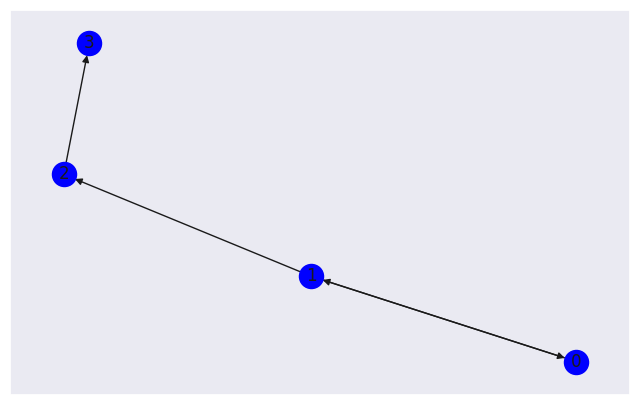

In [ ]:
edge_index_1 = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 3]], dtype=torch.long)
x_1 = torch.tensor([[-1], [0], [1], [2]], dtype=torch.float) #data at nodes.
data_1 = Data(x_1, edge_index = edge_index_1)
visualize_graph(data_1)

In [ ]:
msg_net = MPNN(5, 3)
H = torch.tensor([[1, 2, 3, 4, 5], [5, 6, 7, 8, 9], [9, 10, 11, 12, 13], [13, 14, 15, 16, 17]], dtype = torch.float32)
print("The node feature matrix is", H)
E_in = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 3]])
E = torch.tensor([[3, 6, 9], [12, 15, 18], [21, 24, 27], [30, 33, 36]], dtype = torch.float32)
y = msg_net(H, E_in, E)
print("The updated node feature matrix is", y)

The node feature matrix is tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 9., 10., 11., 12., 13.],
        [13., 14., 15., 16., 17.]])
The updated node feature matrix is tensor([[ 3.1335,  2.5009, -0.7761,  1.1094, -0.8930],
        [-0.8554,  2.1461, -1.4747, -3.4020,  1.4447],
        [ 2.2826,  5.2303, -1.6074, -1.4535,  0.1916],
        [ 3.1224,  7.6064, -1.7969, -2.0773, -0.1216]],
       grad_fn=<AddmmBackward0>)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/JetClass_example_100k.root"
tree = uproot.open(data_file)["tree"]

Mounted at /content/drive


In [ ]:
tree.num_entries

100000

In [ ]:
tree.keys(filter_name = "part_*")

['part_px',
 'part_py',
 'part_pz',
 'part_energy',
 'part_deta',
 'part_dphi',
 'part_d0val',
 'part_d0err',
 'part_dzval',
 'part_dzerr',
 'part_charge',
 'part_isChargedHadron',
 'part_isNeutralHadron',
 'part_isPhoton',
 'part_isElectron',
 'part_isMuon']

In [ ]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [ ]:
tree.show(filter_name = "label_*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
label_QCD            | float                    | AsDtype('>f4')
label_Hbb            | bool                     | AsDtype('bool')
label_Hcc            | bool                     | AsDtype('bool')
label_Hgg            | bool                     | AsDtype('bool')
label_H4q            | bool                     | AsDtype('bool')
label_Hqql           | bool                     | AsDtype('bool')
label_Zqq            | int32_t                  | AsDtype('>i4')
label_Wqq            | int32_t                  | AsDtype('>i4')
label_Tbqq           | int32_t                  | AsDtype('>i4')
label_Tbl            | int32_t                  | AsDtype('>i4')


In [ ]:
tree.show(filter_name = "jet_*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
jet_pt               | float                    | AsDtype('>f4')
jet_eta              | float                    | AsDtype('>f4')
jet_phi              | float                    | AsDtype('>f4')
jet_energy           | float                    | AsDtype('>f4')
jet_nparticles       | float                    | AsDtype('>f4')
jet_sdmass           | float                    | AsDtype('>f4')
jet_tau1             | float                    | AsDtype('>f4')
jet_tau2             | float                    | AsDtype('>f4')
jet_tau3             | float                    | AsDtype('>f4')
jet_tau4             | float                    | AsDtype('>f4')


In [ ]:
tree.show(filter_name = "part_*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [ ]:
table = tree.arrays() #The function returns a list of arrays, where each array corresponds to a branch in the tree. The arrays are ordered in the same order as the branches in the tree.

In [ ]:
table['label_Hcc'].to_numpy() #arrays of boolean datatype converted to numpy array

array([False, False, False, ..., False, False, False])

In [ ]:
np.where(table['label_H4q'].to_numpy()!=0) #np.where() function in Python takes an array and a condition as input and returns the indices of the elements in the array where the condition is satisfied

(array([40000, 40001, 40002, ..., 49997, 49998, 49999]),)

In [ ]:
table["jet_nparticles"] # Each element is the total number of particles that any particular jet contains.

<Array [38, 30, 39, 32, 45, ..., 49, 30, 27, 31, 42] type='100000 * float32'>

In [ ]:
print(len(table["jet_pt"].to_numpy()))
print(len(table["jet_eta"].to_numpy()))
print(len(table["jet_phi"].to_numpy()))
print(len(table["jet_energy"].to_numpy()))
print(len(table["jet_tau2"].to_numpy()))
print(len(table["jet_tau3"].to_numpy()))
print(len(table["jet_tau4"].to_numpy()))
print(len(table["jet_sdmass"].to_numpy())) # The length is same as total number of entries

100000
100000
100000
100000
100000
100000
100000
100000




```
table["part_px"]
```
The output is a jagged array because the number of entries is different for each element in the array. Note that there are square brackets [ ] surrounding the list of entries for each element in the array. The type = "100000 * var * float32" means that there are 100000 rows, each containing a variable number of 32-bit floating point numbers. This is basically an array of arrays (or a 2D array). Each element consists of x-momentum values of particles belonging to a particular jet.


In [ ]:
table["part_px"]

<Array [[-125, -91.1, ..., -1.19, -1.14], ...] type='100000 * var * float32'>

In [ ]:
print(len(table["part_px"][0:1].to_numpy().T), table["jet_nparticles"][0])
print(len(table["part_px"][1:2].to_numpy().T), table["jet_nparticles"][1])
print(len(table["part_px"][2:3].to_numpy().T), table["jet_nparticles"][2])

38 38.0
30 30.0
39 39.0


In [ ]:
feat_list = [ak.flatten(table[part_feat][1000:1001]).to_numpy() for part_feat in tree.keys(filter_name = 'part_*')]
print(feat_list)

[array([209.23755   ,  71.26506   ,  58.62227   ,  48.04897   ,
        35.71879   ,  29.575531  ,  29.0879    ,  23.740774  ,
        21.325333  ,  17.73414   ,  14.641778  ,  11.158691  ,
        11.1164665 ,  12.474273  ,   9.652728  ,   9.161711  ,
         9.2758465 ,   8.499504  ,   9.084895  ,   6.876359  ,
         5.634165  ,   4.6805496 ,   4.553557  ,   3.7666163 ,
         4.662428  ,   4.259133  ,   3.3212311 ,   3.2712321 ,
         3.449662  ,   3.2211046 ,   2.7937016 ,   2.609154  ,
         2.463435  ,   2.6051676 ,   2.344007  ,   2.1937962 ,
         1.5571802 ,   1.5164233 ,   1.1854081 ,   1.0381104 ,
         0.88003755,   0.41359824], dtype=float32), array([-94.75879   , -40.83561   , -27.575617  , -22.066963  ,
       -25.305702  , -13.395693  , -13.188413  ,  -9.914301  ,
        -9.112465  ,  -7.7714005 ,  -6.477691  ,  -9.776557  ,
        -8.325022  ,  -5.784739  ,  -3.760091  ,  -3.8027878 ,
        -2.1147752 ,  -3.9288673 ,  -1.5287609 ,  -4.9632554 ,
  

In [ ]:
np.stack(feat_list).T.shape, len(tree.keys(filter_name='part_*'))

((42, 16), 16)

In [ ]:
# Construct a Lorentz 4-vector from the (px, py, pz, energy) arrays
p4 = vector.zip({'px': table['part_px'], 'py': table['part_py'], 'pz': table['part_pz'], 'energy': table['part_energy']})

In [ ]:
p4.mass

<Array [[0.0442, 0, ..., 0.000345], ..., [...]] type='100000 * var * float32'>

In [ ]:
idx = 12000
ak.flatten(p4.pt[idx:idx+1]).to_numpy().mean(), ak.flatten(p4.pt[idx:idx+1]).to_numpy().std()

(17.975435, 22.76201)

In [ ]:
ak.flatten(p4.phi[idx:idx+1]).to_numpy().mean(), ak.flatten(p4.phi[idx:idx+1]).to_numpy().std()

(-1.5115892, 0.14769214)

In [ ]:
jet_sdmass = table['jet_sdmass'].to_numpy()

In [ ]:
jet_sdmass_H = jet_sdmass[np.where(table['label_Hbb'].to_numpy()!=0)]
jet_sdmass_T = jet_sdmass[np.where(table['label_Tbqq'].to_numpy()!=0)]

In [ ]:
jet_sdmass_H

array([ 91.98812,  17.3149 , 124.49392, ..., 150.37427, 140.32726,
       131.21666], dtype=float32)

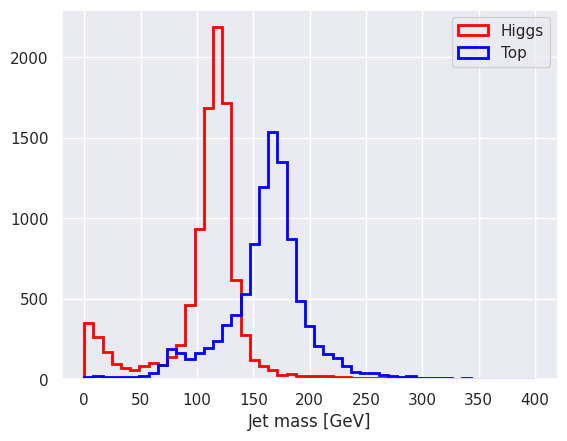

In [ ]:
plt.hist(jet_sdmass_H, bins = np.linspace(0, 400, 50), label = 'Higgs', color = 'red', histtype = 'step', linewidth = 2.)
plt.hist(jet_sdmass_T, bins = np.linspace(0, 400, 50), label = 'Top', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel('Jet mass [GeV]')
plt.legend()
plt.show()

## The data
PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package **torch.utils.data**.
```
import torch.utils.data as data
```
The data package defines two classes which are the standard interface for handling data in PyTorch : **data.Dataset** and **data.DataLoader**. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.


## The dataset class
The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions :
\__getitem__\, and \__len__\. The get-item function has to return the
i-th data point in the dataset, while the len function returns the size of the dataset.

## XOR dataset

In [ ]:
class XORdataset(data.Dataset) :
  def __init__(self, n_points, std = 0.1) :
    super().__init__()
    self.n_points = n_points
    self.std = std
    self.datapoints_generator()

  def datapoints_generator(self) :
    data = torch.randint(0, 2, (self.n_points, 2), dtype = torch.float32)
    label = (data.sum(dim = 1) == 1).to(torch.long)
    # The data.sum(dim = 1) function sums the elements of each row in the data tensor.
    # The (data.sum(dim = 1) == 1) expression returns a tensor of Boolean values,
    # where True indicates that the sum of the elements in each row is equal to 1.
    # The to(torch.long) function converts the Boolean tensor to a long tensor.
    data += self.std*torch.randn(data.shape) # Adding Gaussian noise to the datapoints.

    self.data = data
    self.label = label

  def __len__(self) :
    return self.n_points

  def __getitem__(self, idx) :
    return self.data[idx], self.label[idx]

In [ ]:
data_1 = XORdataset(108)
print("Total number of datapoints is", len(data_1))
print("The first element of the dataset is", data_1[0])

Total number of datapoints is 108
The first element of the dataset is (tensor([1.0269, 0.9834]), tensor(0))


## Visualizing XOR dataset

In [ ]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize = (4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor = "#333", label = "Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("XORdatasets")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

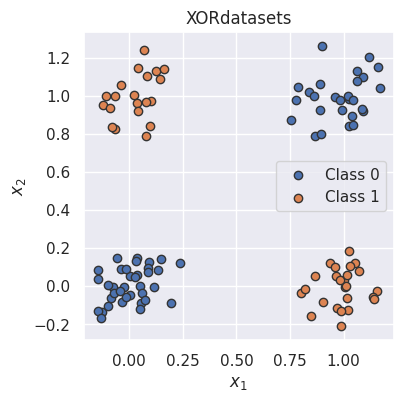

In [ ]:
visualize_samples(data_1.data, data_1.label)

## Jet dataset

In [ ]:
class Jetdataset(data.Dataset):

    def __init__(self, dataset_path : str, tree_name : str = "tree") :
        super().__init__()
        self.dataset = uproot.open(dataset_path) # Opens the ROOT file specified by the dataset_path variable
        self.tree = self.dataset[tree_name].arrays() # Reads the data from the tree named tree_name in the ROOT file. The data is returned as a numpy array.
        self.num_entries = self.dataset[tree_name].num_entries
        self.part_feat = self.dataset[tree_name].keys(filter_name = "part_*")
        self.jet_feat = self.dataset[tree_name].keys(filter_name = "jet_*")
        self.labels = self.dataset[tree_name].keys(filter_name = "labels_*")

    def transform_jet_to_point_cloud(self, idx : int) :
        npart = self.tree['jet_nparticles'].to_numpy()[idx:idx+1]

        part_feat_list = [ak.flatten(self.tree[part_feat][idx:idx+1]).to_numpy() for part_feat in self.part_feat]

        jet_pt = self.tree['jet_pt'].to_numpy()[idx:idx+1]
        jet_eta = self.tree['jet_eta'].to_numpy()[idx:idx+1]
        jet_phi = self.tree['jet_phi'].to_numpy()[idx:idx+1]
        jet_energy = self.tree['jet_energy'].to_numpy()[idx:idx+1]
        jet_tau21 = self.tree['jet_tau2'].to_numpy()[idx:idx+1]/self.tree['jet_tau1'].to_numpy()[idx:idx+1]
        jet_tau32 = self.tree['jet_tau3'].to_numpy()[idx:idx+1]/self.tree['jet_tau2'].to_numpy()[idx:idx+1]
        jet_tau43 = self.tree['jet_tau4'].to_numpy()[idx:idx+1]/self.tree['jet_tau3'].to_numpy()[idx:idx+1]

        jet_sd_mass = self.tree['jet_sdmass'].to_numpy()[idx:idx+1]

        jet_feat = np.stack([jet_pt, jet_eta, jet_phi, jet_energy, jet_tau21, jet_tau32, jet_tau43]).T
        jet_feat = np.repeat(jet_feat, int(npart), axis=0)

        part_feat = np.stack(part_feat_list).T

        total_jet_feat = np.concatenate((part_feat, jet_feat), axis=-1) # The part_feat to the left and jet_feat to the right.
        total_jet_feat[np.isnan(total_jet_feat)] = 0.

        print(type(total_jet_feat), "total_jet_feat shape : ", total_jet_feat.shape)

        jet_class = -1

        if (self.tree['label_QCD'].to_numpy()[idx:idx+1] == 1) : jet_class = 0

        if ((self.tree['label_Tbqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Tbl'].to_numpy()[idx:idx+1] == 1)) : jet_class = 3

        if ((self.tree['label_Zqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Wqq'].to_numpy()[idx:idx+1] == 1)) : jet_class = 2

        if ((self.tree['label_Hbb'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hcc'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hgg'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_H4q'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hqql'].to_numpy()[idx:idx+1] == True)) : jet_class = 1

        return {'jet' : torch.tensor(total_jet_feat), 'label' : torch.tensor([jet_class]), 'seq_length' : torch.tensor(npart), 'sd_mass' : torch.tensor(jet_sd_mass)}


    def __len__(self) -> int:
        return self.num_entries

    def __getitem__(self, idx:int) -> dict :
        # Returns the idx-th data point of the dataset
        return self.transform_jet_to_point_cloud(idx)

In [ ]:
jet_data = Jetdataset(data_file)

In [ ]:
jet_data[1] # The data features of the second jet. Note that the second jet contains 30 particles.

<class 'numpy.ndarray'> total_jet_feat shape :  (30, 23)


{'jet': tensor([[ 1.1002e+02,  2.1854e+02, -4.6105e+02,  5.2195e+02,  1.5350e-02,
          -4.8961e-02, -7.4715e-02,  8.8000e-03,  1.4319e-01,  3.0900e-02,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.1168e+03,
           3.2344e-01,  8.2283e-01,  8.8591e-01],
         [ 2.7932e+01,  5.5724e+01, -1.1504e+02,  1.3085e+02, -2.9423e-03,
          -4.7234e-02,  1.3696e-02,  1.0200e-02, -9.4947e-01,  3.4300e-02,
           1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.1168e+03,
           3.2344e-01,  8.2283e-01,  8.8591e-01],
         [ 2.0905e+01,  4.0030e+01, -8.6801e+01,  9.7846e+01,  3.2901e-02,
          -6.3858e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.116

In [ ]:
jet_data[1]["jet"] # Accessing the jet features of the second jet

<class 'numpy.ndarray'> total_jet_feat shape :  (30, 23)


tensor([[ 1.1002e+02,  2.1854e+02, -4.6105e+02,  5.2195e+02,  1.5350e-02,
         -4.8961e-02, -7.4715e-02,  8.8000e-03,  1.4319e-01,  3.0900e-02,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.1168e+03,
          3.2344e-01,  8.2283e-01,  8.8591e-01],
        [ 2.7932e+01,  5.5724e+01, -1.1504e+02,  1.3085e+02, -2.9423e-03,
         -4.7234e-02,  1.3696e-02,  1.0200e-02, -9.4947e-01,  3.4300e-02,
          1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.1168e+03,
          3.2344e-01,  8.2283e-01,  8.8591e-01],
        [ 2.0905e+01,  4.0030e+01, -8.6801e+01,  9.7846e+01,  3.2901e-02,
         -6.3858e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  5.2832e+02, -1.3753e+00,  1.1534e+00,  1.1168e+03,
          3.23

In [ ]:
jet_data[2] # The data features of the third jet. Note that the third jet contains 39 particles.

<class 'numpy.ndarray'> total_jet_feat shape :  (39, 23)


{'jet': tensor([[ 1.2854e+02, -6.3017e+01,  2.9013e+02,  3.2353e+02, -1.3630e-01,
          -1.6688e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  5.0379e+02,  1.5918e+00, -4.3912e-01,  1.2951e+03,
           2.9324e-01,  8.2866e-01,  8.4761e-01],
         [ 8.1740e+01, -4.1089e+01,  1.8274e+02,  2.0436e+02, -1.4928e-01,
          -2.6670e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  5.0379e+02,  1.5918e+00, -4.3912e-01,  1.2951e+03,
           2.9324e-01,  8.2866e-01,  8.4761e-01],
         [ 2.2781e+01, -1.1171e+01,  4.9498e+01,  5.5622e+01, -1.7036e-01,
          -1.6803e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  5.0379e+02,  1.5918e+00, -4.3912e-01,  1.295

In [ ]:
jet_data[99999] # The data features of the last jet. Note that the last jet contains 42 particles.

<class 'numpy.ndarray'> total_jet_feat shape :  (42, 23)


{'jet': tensor([[-1.2158e+02, -1.2044e+02, -1.6142e+02,  2.3525e+02, -8.0164e-02,
          -3.8896e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  7.6542e+02, -9.2082e-01, -2.3570e+00,  1.1201e+03,
           4.0573e-01,  7.1883e-01,  8.5984e-01],
         [-7.6377e+01, -9.4774e+01, -1.6661e+02,  2.0633e+02,  1.9889e-01,
           1.0788e-01,  4.1198e-03,  1.0200e-02,  2.9571e-02,  3.4300e-02,
           1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  7.6542e+02, -9.2082e-01, -2.3570e+00,  1.1201e+03,
           4.0573e-01,  7.1883e-01,  8.5984e-01],
         [-3.5257e+01, -4.8153e+01, -7.5295e+01,  9.6079e+01,  1.3403e-01,
           1.5420e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  7.6542e+02, -9.2082e-01, -2.3570e+00,  1.120

## The data loader class
The class **torch.utils.data.DataLoader** represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function \__getitem__\, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input.
Additionally, we can configure our data loader with the following input arguments :

1. batch_size : Number of samples to stack per batch
1. shuffle : If True, the data is returned in a random order. This is important during training for introducing stochasticity.
1. num_workers : Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
1. pin_memory : If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
1. drop_last : If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

In [ ]:
dataloader = data.DataLoader(data_1, batch_size = 12, shuffle = True) # Total entries is 108, so number of batches is 108/12 i.e 9 batches.
i = 0
for batch in dataloader :
  i = i + 1
  print("Batch", i, batch)

Batch 1 [tensor([[ 1.0237,  0.8432],
        [ 0.0879,  0.0967],
        [ 0.9607,  0.1006],
        [ 0.1465,  0.1451],
        [-0.1097,  0.9961],
        [ 1.0018,  0.0314],
        [ 1.0639,  1.1292],
        [ 0.7851,  1.0462],
        [-0.1441, -0.1312],
        [ 0.8473, -0.1568],
        [-0.0452, -0.0255],
        [ 0.1030,  0.9719]]), tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1])]
Batch 2 [tensor([[ 0.9377,  0.1207],
        [ 0.9871, -0.1267],
        [-0.1468,  0.0876],
        [ 1.0224,  0.9976],
        [ 0.7527,  0.8750],
        [-0.0904,  0.9369],
        [-0.0867, -0.0586],
        [ 0.9824,  0.9788],
        [ 0.0979,  0.8410],
        [ 1.0229,  0.1854],
        [ 1.0637,  1.0747],
        [-0.0392,  0.0886]]), tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])]
Batch 3 [tensor([[-0.0671,  1.0002],
        [ 0.0784,  0.9686],
        [ 0.0903,  0.1269],
        [ 0.0417,  1.1467],
        [ 0.0839,  1.1046],
        [ 0.0367,  0.9632],
        [ 0.1633,  1.1375],
        [

## KNN graph (knn_graph)
Computes graph edges to the nearest k-points.


```
from torch_geometric.nn import knn_graph
```
**Parameters** :
1. **x** (**torch.Tensor**) : node features matrix, $X_{n \times d}$, n is the number of nodes and d is the dimension of each node feature.
1. **k** (**int**) : number of neighbors.

[knn_graph](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.knn_graph.html)


## Data handling of graphs
A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of **torch_geometric.data.Data**, which holds the following attributes by default :
1. **data.x** : Node feature matrix with shape **[num_nodes, num_node_features]**

1. **data.edge_index** : Graph connectivity in COO format with shape **[2, num_edges]** and type **torch.long**

1. **data.edge_attr** : Edge feature matrix with shape **[num_edges, num_edge_features]**


```
from torch_geometric.data import Data
```
[Data](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#data-handling-of-graphs)


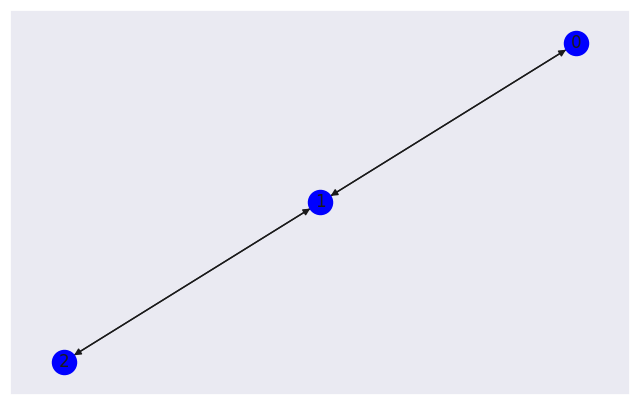

In [ ]:
edge_index = torch.tensor([[0, 1, 1, 2],[1, 0, 2, 1]], dtype = torch.long)
x = torch.tensor([[-1], [0], [1]], dtype = torch.float)
data_2 = Data(x, edge_index = edge_index)
visualize_graph(data_2)

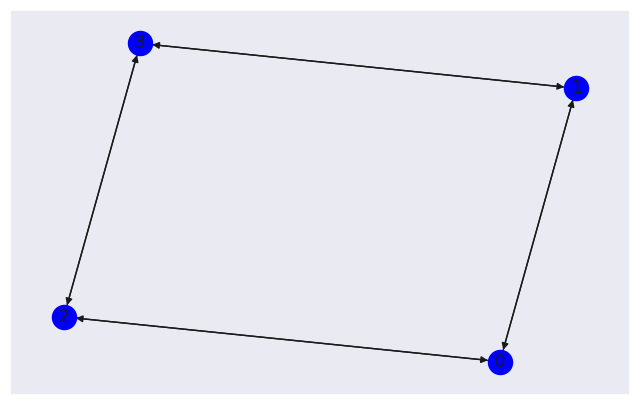

In [ ]:
x = torch.tensor([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
edge_index = knn_graph(x, k = 2)
data_3 = Data(x, edge_index = edge_index)
visualize_graph(data_3)

The source nodes : tensor([1, 2, 3, 0, 3, 2, 0, 3, 1, 1, 2, 0])
The target nodes : tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])
tensor([[1, 2, 3, 0, 3, 2, 0, 3, 1, 1, 2, 0],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]])


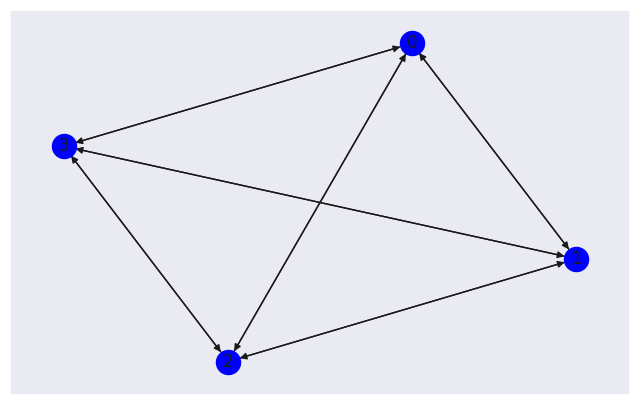

In [ ]:
x = torch.tensor([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
edge_index = knn_graph(x, k = 4)
src, dst = edge_index # src : source node, dst : destination node
print("The source nodes :", src)
print("The target nodes :", dst)
print(edge_index)
data_4 = Data(x, edge_index = edge_index)
visualize_graph(data_4)

## Jet graph dataset

In [112]:
class Jet_dataset(data.Dataset):

    def __init__(self, dataset_path : str, tree_name : str = 'tree', k : int = 5) :
        super().__init__()
        self.dataset = uproot.open(dataset_path)
        self.tree = self.dataset[tree_name].arrays()
        self.num_entries = self.dataset[tree_name].num_entries
        self.part_feat = self.dataset[tree_name].keys(filter_name='part_*')
        self.jet_feat = self.dataset[tree_name].keys(filter_name='jet_*')
        self.labels = self.dataset[tree_name].keys(filter_name='labels_*')
        self.k = k

    def transform_jet_to_point_cloud(self, idx : int) :
        npart = self.tree['jet_nparticles'].to_numpy()[idx:idx+1]

        part_feat_list = [ak.flatten(self.tree[part_feat][idx:idx+1]).to_numpy() for part_feat in self.part_feat]

        jet_pt = self.tree['jet_pt'].to_numpy()[idx:idx+1]
        jet_eta = self.tree['jet_eta'].to_numpy()[idx:idx+1]
        jet_phi = self.tree['jet_phi'].to_numpy()[idx:idx+1]
        jet_energy = self.tree['jet_energy'].to_numpy()[idx:idx+1]
        jet_tau21 = self.tree['jet_tau2'].to_numpy()[idx:idx+1]/self.tree['jet_tau1'].to_numpy()[idx:idx+1]
        jet_tau32 = self.tree['jet_tau3'].to_numpy()[idx:idx+1]/self.tree['jet_tau2'].to_numpy()[idx:idx+1]
        jet_tau43 = self.tree['jet_tau4'].to_numpy()[idx:idx+1]/self.tree['jet_tau3'].to_numpy()[idx:idx+1]


        jet_sd_mass = self.tree['jet_sdmass'].to_numpy()[idx:idx+1]
        jet_feat = np.stack([jet_pt, jet_eta, jet_phi, jet_energy, jet_tau21, jet_tau32, jet_tau43]).T
        jet_feat = np.repeat(jet_feat, int(npart), axis=0)
        part_feat = np.stack(part_feat_list).T
        total_jet_feat = np.concatenate((part_feat, jet_feat), axis=-1)
        total_jet_feat[np.isnan(total_jet_feat)] = 0.

        # print(type(total_jet_feat), 'total_jet_feat shape :', total_jet_feat.shape)

        jet_class = -1

        if(self.tree['label_QCD'].to_numpy()[idx:idx+1] == 1) : jet_class = 0

        if( (self.tree['label_Tbqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Tbl'].to_numpy()[idx:idx+1] == 1)) : jet_class = 2

        if( (self.tree['label_Zqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Wqq'].to_numpy()[idx:idx+1] == 1)) : jet_class = 0

        if( (self.tree['label_Hbb'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hcc'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hgg'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_H4q'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hqql'].to_numpy()[idx:idx+1] == True) ) : jet_class = 1

        part_eta = torch.tensor( ak.flatten(self.tree['part_deta'][idx:idx+1]).to_numpy() )
        part_phi = torch.tensor( ak.flatten(self.tree['part_dphi'][idx:idx+1]).to_numpy() )
        eta_phi_pos = torch.stack([part_eta, part_phi], dim = -1)

        edge_index = torch_geometric.nn.pool.knn_graph(x = eta_phi_pos, k = self.k)

        src, dst = edge_index

        part_del_eta = part_eta[dst] - part_eta[src]
        part_del_phi = part_phi[dst] - part_phi[src]
        part_del_R = torch.hypot(part_del_eta, part_del_phi).view(-1, 1)

        data = Data(x=torch.tensor(total_jet_feat), edge_index=edge_index, edge_attr = part_del_R)
        # Adding additional arguments to data
        data.label = torch.tensor([jet_class])
        data.sd_mass = torch.tensor(jet_sd_mass)
        data.seq_length = torch.tensor(npart)
        # data : {x : node feature matrix, edge_index : a matrix representing edge connections,
        #         edge_attr : edge feature matrix, label : jet_class, sd_mass : jet_sd_mass,
        #         seq_length : number of particles in the given jet}
        # Can be accessed using data.label, data.sd_mass, data.seq_length
        return data


    def __len__(self) -> int:
        return self.num_entries

    def __getitem__(self, idx:int) -> Data :
        return self.transform_jet_to_point_cloud(idx)

In [ ]:
jet_graph_data = Jet_dataset(data_file)

torch.Size([38, 23])
torch.Size([190, 1])
The node feature matrix is tensor([[-1.2458e+02,  6.4302e+01, -3.6051e+01,  1.4475e+02, -7.2420e-02,
         -8.5811e-02,  7.7095e-02,  1.1000e-02,  3.0595e-02,  3.1800e-02,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  8.1074e+02, -3.2682e-01,  2.7509e+00,  8.5968e+02,
          2.4527e-01,  6.7589e-01,  8.4978e-01],
        [-9.1081e+01,  2.7990e+01, -3.9437e+01,  1.0312e+02,  7.6079e-02,
          9.2534e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  8.1074e+02, -3.2682e-01,  2.7509e+00,  8.5968e+02,
          2.4527e-01,  6.7589e-01,  8.4978e-01],
        [-8.3185e+01,  2.8240e+01, -3.7306e+01,  9.5441e+01,  8.6017e-02,
          6.3405e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+0

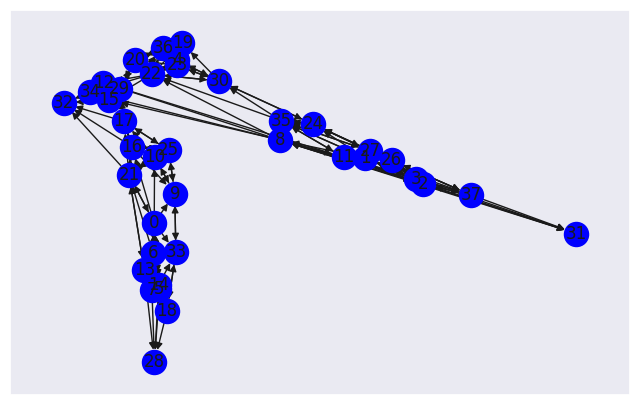

In [108]:
jet_1 = jet_graph_data[0] # Accessing the first jet data
print(jet_1.x.shape) # Feature matrix shape
print(jet_1.edge_attr.shape)
print("The node feature matrix is", jet_1.x) # Node feature matrix or feature matrix of particles in the 1st jet
print("First particle feature vector :", jet_1.x[0]) # Feature vector of the 1st particle in the jet
print("Last particle feature vector :", jet_1.x[37]) # Feature vector of the last particle in the jet
print("The jet contains", int(jet_1.seq_length), "number of particles and it belongs to jet_class", int(jet_1.label))
visualize_graph(jet_1)

The jet contains 30 number of particles and it belongs to jet_class 1


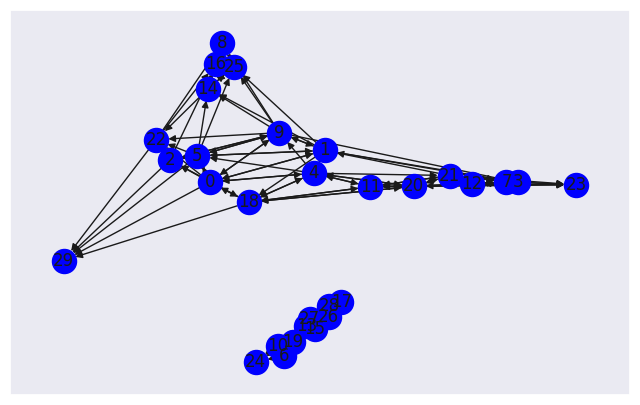

In [ ]:
jet_2 = jet_graph_data[1] # Accessing the second jet data
print("The jet contains", int(jet_2.seq_length), "number of particles and it belongs to jet_class", int(jet_2.label))
visualize_graph(jet_2)

The jet contains 42 number of particles and it belongs to jet_class 0


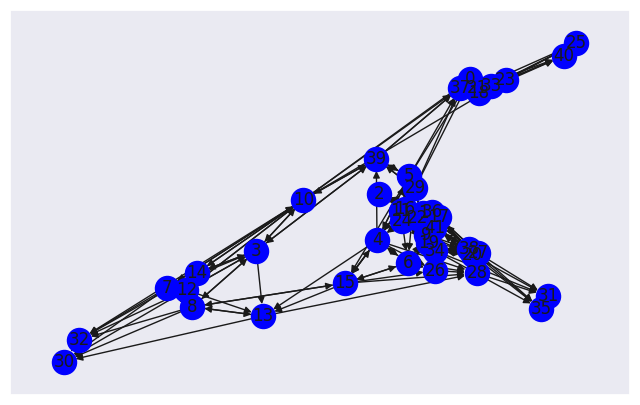

In [101]:
jet_100000 = jet_graph_data[99999] # Accessing the last jet data
print("The jet contains", int(jet_100000.seq_length), "number of particles and it belongs to jet_class", int(jet_100000.label))
visualize_graph(jet_100000)

## MPNN model

In [107]:
class MPNNmodel(Module):
    def __init__(self, num_layers, hid_dim, in_dim, edge_dim, out_dim):
        # num_layers: (int) - number of message passing layers, L
        # hid_dim: (int) - hidden dimension, d
        # in_dim: (int) - initial node feature dimension, d_n
        # edge_dim: (int) - edge feature dimension, d_e
        # out_dim: (int) - output dimension (fixed to 1)
        super().__init__()
        self.lin_in = Linear(in_dim, hid_dim)
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNN(hid_dim, edge_dim, aggr = "add"))
        self.pool = global_mean_pool
        # Linear prediction head
        self.lin_pred = Linear(hid_dim, out_dim)

    def forward(self, data):
        # data: (PyG.Data) - batch of PyG graphs
        # out: (batch_size, out_dim) - prediction for each graph
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        for conv in self.convs:
            h = h + conv(h = h, edge_index = data.edge_index, edge_attr = data.part_del_R) # (n, d) -> (n, d)
        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)
        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [113]:
#data_loader = DataLoader(dataset=Jet_dataset, batch_size=3, shuffle = True)
#b_gr = next(iter(data_loader))
#mpnn_model = MPNNmodel(num_layers=4, emb_dim=64, in_dim=23, edge_dim=1, out_dim=1)
#out = mpnn_model(b_gr)

TypeError: object of type 'type' has no len()